# Housing Price Prediction

This notebook will load data, train a Random Forest regressor, evaluate it, and generate SHAP explanations.


In [1]:
# Cell 1: imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import shap
import joblib

# for nicer plots
plt.style.use('default')

c:\Users\alexc\anaconda3\envs\hci\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the dataset


In [2]:
df = pd.read_csv("Housing.csv")      # or your chosen CSV
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Feature engineering

In [3]:
print(df.shape)
df.describe().T
df.isna().sum().sort_values(ascending=False).head(10)


(545, 13)


price              0
area               0
bedrooms           0
bathrooms          0
stories            0
mainroad           0
guestroom          0
basement           0
hotwaterheating    0
airconditioning    0
dtype: int64

In [4]:
df.columns 

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

## Encodeing categorical data

In [5]:
from sklearn.preprocessing import OrdinalEncoder
cat_cols = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea",
    "furnishingstatus",
]

enc = OrdinalEncoder()

# learns an integer code for each unique label
df[cat_cols] = enc.fit_transform(df[cat_cols].astype(str))


In [6]:
df.head(9)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1.0,0.0,0.0,0.0,1.0,2,1.0,0.0
1,12250000,8960,4,4,4,1.0,0.0,0.0,0.0,1.0,3,0.0,0.0
2,12250000,9960,3,2,2,1.0,0.0,1.0,0.0,0.0,2,1.0,1.0
3,12215000,7500,4,2,2,1.0,0.0,1.0,0.0,1.0,3,1.0,0.0
4,11410000,7420,4,1,2,1.0,1.0,1.0,0.0,1.0,2,0.0,0.0
5,10850000,7500,3,3,1,1.0,0.0,1.0,0.0,1.0,2,1.0,1.0
6,10150000,8580,4,3,4,1.0,0.0,0.0,0.0,1.0,2,1.0,1.0
7,10150000,16200,5,3,2,1.0,0.0,0.0,0.0,0.0,0,0.0,2.0
8,9870000,8100,4,1,2,1.0,1.0,1.0,0.0,1.0,2,1.0,0.0


In [7]:
X = df.drop("price", axis=1)
y = df["price"]


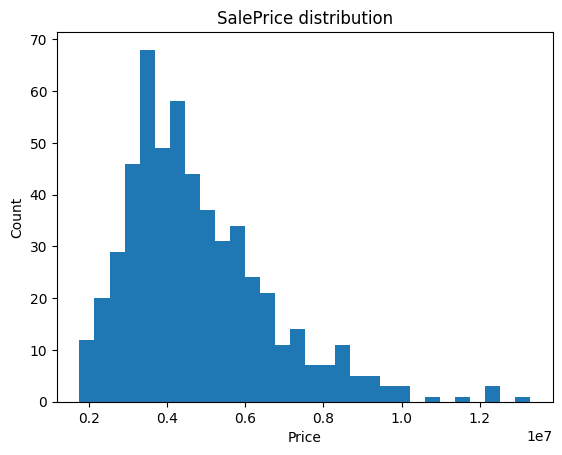

In [8]:
# Inspect distributions
plt.hist(y, bins=30)
plt.title("SalePrice distribution")
plt.xlabel("Price"); plt.ylabel("Count")
plt.show()


# Model creation

In [75]:
## Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (381, 12) Test: (164, 12)


In [76]:
X_train.to_csv('train_features.csv')

In [89]:
## Train a Random Forest regressor
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    max_leaf_nodes=100
)
model.fit(X_train, y_train)



RandomForestRegressor(max_depth=8, max_leaf_nodes=100, n_estimators=200,
                      n_jobs=-1, random_state=42)

# Evaluation

In [88]:
preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("R²: ", r2_score(y_test, preds))


MAE: 962828.001630203
R²:  0.5739349782658532


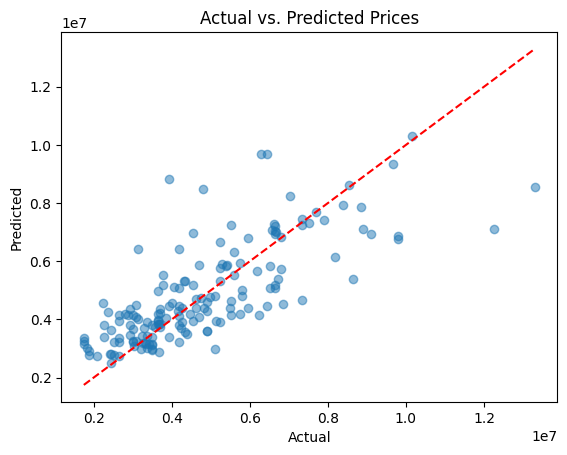

In [ ]:
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Prices")
plt.show()


## SHAP explanations

In [14]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


### Global feature importance

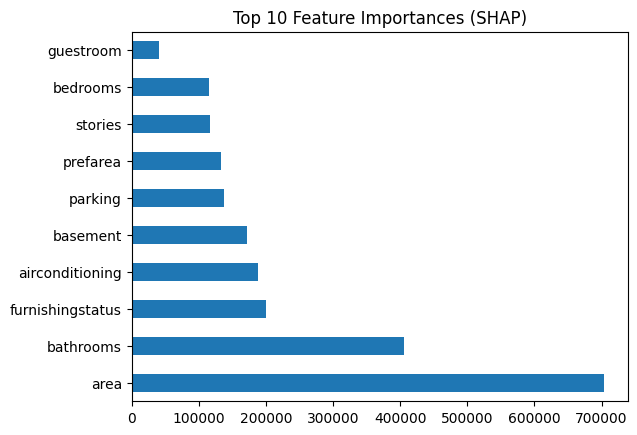

In [15]:
imp = np.abs(shap_values.values).mean(axis=0)
feat_imp = pd.Series(imp, index=X.columns).sort_values(ascending=False)
feat_imp.head(10).plot.barh()
plt.title("Top 10 Feature Importances (SHAP)")
plt.show()


### Local explanation for a single example

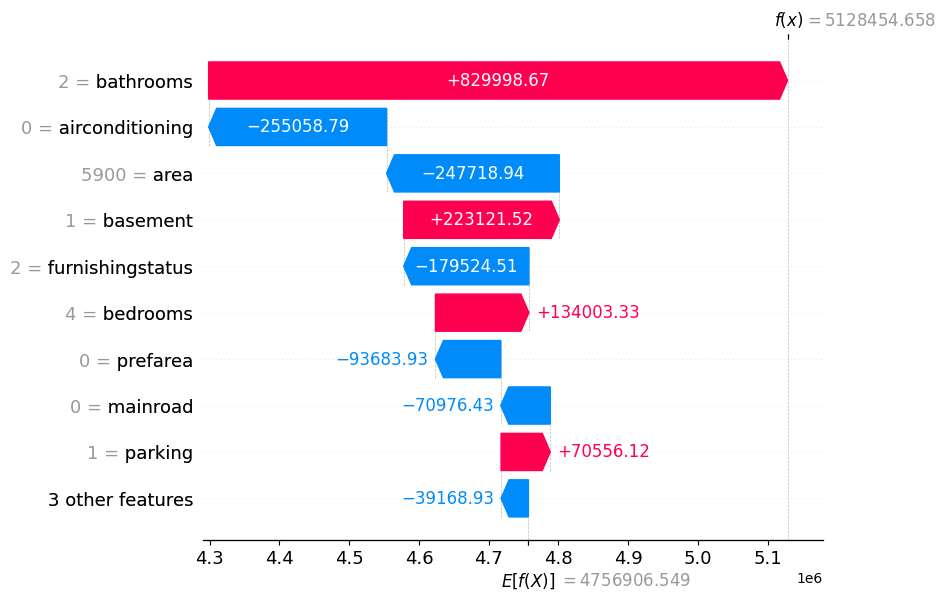

In [16]:
idx = 0  # or change to any row index
shap.plots.waterfall(shap_values[idx])


# Save model & explainer

In [17]:
# Cell 13
joblib.dump(model, "house_price_rf.pkl")
joblib.dump(explainer, "shap_explainer.pkl")

['shap_explainer.pkl']

# 2nd Model Gradiant Booster Regressor

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": [10,50,100, 200, 300],
    "max_depth": [1,2,3,5,4, 6, 8, None],
}

grid = GridSearchCV(GradientBoostingRegressor(random_state=42), params, cv=3, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

Best parameters: {'max_depth': 3, 'n_estimators': 50}
Best MAE: 765277.7515282715


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=150, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)
print("Gradient Boosting MAE:", mean_absolute_error(y_test, gbr_preds))
print("Gradient Boosting R²:", r2_score(y_test, gbr_preds))

Gradient Boosting MAE: 924735.041347385
Gradient Boosting R²: 0.6329806248860892


In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [1, 3, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=3, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}
Best MAE: 761079.5219307373


In [20]:
results = {}
for name, model in [
    ("Random Forest", RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)),
    # ("Linear Regression", LinearRegression()),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42))
    # ("Lasso", Lasso(alpha=0.1))
]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MAE": mae, "R2": r2}

import pandas as pd
pd.DataFrame(results).T

,MAE,R2
Random Forest,959190.554412,0.576388
Gradient Boosting,941663.335904,0.581628


In [68]:
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 22.49%
